# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/features/features_{GEO}_3.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1546, 96)


,embedding_comments_0,embedding_comments_1,embedding_comments_2,embedding_description_0,embedding_description_1,embedding_description_2,3gram09_would_not_recommend,3gram09_no_toilet_paper,3gram09_not_recommend_staying,3gram09_write_negative_review,...,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_waterfront,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,-0.474145,-0.014660,1.812986,0.173191,0.472598,1.787511,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
133337,-0.062028,0.003106,1.861215,0.173191,0.472598,1.787511,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
150928,-0.553971,-0.034921,1.809168,0.173191,0.472598,1.787511,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
2706775,-0.454356,-0.185390,1.936598,0.173191,0.472598,1.787511,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
8602878,-0.483645,-0.044557,1.766620,0.173191,0.472598,1.787511,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good


In [18]:
df.label.value_counts()

good     1236
mbad      124
mgood     106
bad        80
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [19]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [20]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1236
mgood    1236
mbad     1236
bad      1236
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [6]:
import itertools

feature_sets = [
    "embedding_comments_",
    "embedding_description_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 63


In [7]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../data/processed/top_models_{GEO}.pickle", "wb") as f:
    pickle.dump(top_models, f)

Testing feature sets combination 1 of 63 (['embedding_comments_'])


100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


Top model for ['embedding_comments_']: ExtraTreesClassifier. Accuracy = 0.9555106167846309
New best model found! Accuracy = 0.9555106167846309

Testing feature sets combination 2 of 63 (['embedding_description_'])


100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Top model for ['embedding_description_']: RandomForestClassifier. Accuracy = 0.8220424671385238

Testing feature sets combination 3 of 63 (['3gram09_'])


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Top model for ['3gram09_']: SVC. Accuracy = 0.2780586450960566

Testing feature sets combination 4 of 63 (['3gram10_'])


100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Top model for ['3gram10_']: QuadraticDiscriminantAnalysis. Accuracy = 0.28412537917087965

Testing feature sets combination 5 of 63 (['amenity005_'])


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Top model for ['amenity005_']: LGBMClassifier. Accuracy = 0.3538928210313448

Testing feature sets combination 6 of 63 (['amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.22it/s]


Top model for ['amenityall_']: BaggingClassifier. Accuracy = 0.48028311425682507

Testing feature sets combination 7 of 63 (['embedding_comments_', 'embedding_description_'])


100%|██████████| 29/29 [00:22<00:00,  1.28it/s]


Top model for ['embedding_comments_', 'embedding_description_']: ExtraTreesClassifier. Accuracy = 0.9787664307381193
New best model found! Accuracy = 0.9787664307381193

Testing feature sets combination 8 of 63 (['embedding_comments_', '3gram09_'])


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Top model for ['embedding_comments_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.9403437815975733

Testing feature sets combination 9 of 63 (['embedding_comments_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.83it/s]


Top model for ['embedding_comments_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.961577350859454

Testing feature sets combination 10 of 63 (['embedding_comments_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Top model for ['embedding_comments_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9534883720930233

Testing feature sets combination 11 of 63 (['embedding_comments_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Top model for ['embedding_comments_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9646107178968655

Testing feature sets combination 12 of 63 (['embedding_description_', '3gram09_'])


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Top model for ['embedding_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8270980788675429

Testing feature sets combination 13 of 63 (['embedding_description_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['embedding_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8412537917087968

Testing feature sets combination 14 of 63 (['embedding_description_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Top model for ['embedding_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8746208291203236

Testing feature sets combination 15 of 63 (['embedding_description_', 'amenityall_'])


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Top model for ['embedding_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8928210313447927

Testing feature sets combination 16 of 63 (['3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:22<00:00,  1.26it/s]


Top model for ['3gram09_', '3gram10_']: SVC. Accuracy = 0.27906976744186046

Testing feature sets combination 17 of 63 (['3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:36<00:00,  1.26s/it]


Top model for ['3gram09_', 'amenity005_']: LGBMClassifier. Accuracy = 0.37209302325581395

Testing feature sets combination 18 of 63 (['3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.27s/it]


Top model for ['3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4752275025278059

Testing feature sets combination 19 of 63 (['3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Top model for ['3gram10_', 'amenity005_']: LGBMClassifier. Accuracy = 0.3700707785642063

Testing feature sets combination 20 of 63 (['3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Top model for ['3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48938321536905965

Testing feature sets combination 21 of 63 (['amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.4863498483316481

Testing feature sets combination 22 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_'])


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.9686552072800809

Testing feature sets combination 23 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_'])


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9737108190091001

Testing feature sets combination 24 of 63 (['embedding_comments_', 'embedding_description_', 'amenity005_'])


100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


Top model for ['embedding_comments_', 'embedding_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9696663296258847

Testing feature sets combination 25 of 63 (['embedding_comments_', 'embedding_description_', 'amenityall_'])


100%|██████████| 29/29 [00:30<00:00,  1.03s/it]


Top model for ['embedding_comments_', 'embedding_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9716885743174924

Testing feature sets combination 26 of 63 (['embedding_comments_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Top model for ['embedding_comments_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9555106167846309

Testing feature sets combination 27 of 63 (['embedding_comments_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Top model for ['embedding_comments_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9625884732052579

Testing feature sets combination 28 of 63 (['embedding_comments_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.25s/it]


Top model for ['embedding_comments_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9595551061678463

Testing feature sets combination 29 of 63 (['embedding_comments_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


Top model for ['embedding_comments_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9524772497472194

Testing feature sets combination 30 of 63 (['embedding_comments_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Top model for ['embedding_comments_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9646107178968655

Testing feature sets combination 31 of 63 (['embedding_comments_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Top model for ['embedding_comments_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9524772497472194

Testing feature sets combination 32 of 63 (['embedding_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Top model for ['embedding_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8099089989888777

Testing feature sets combination 33 of 63 (['embedding_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Top model for ['embedding_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8634984833164813

Testing feature sets combination 34 of 63 (['embedding_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


Top model for ['embedding_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8988877654196158

Testing feature sets combination 35 of 63 (['embedding_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Top model for ['embedding_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8766430738119313

Testing feature sets combination 36 of 63 (['embedding_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['embedding_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8867542972699697

Testing feature sets combination 37 of 63 (['embedding_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Top model for ['embedding_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8897876643073812

Testing feature sets combination 38 of 63 (['3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


Top model for ['3gram09_', '3gram10_', 'amenity005_']: LGBMClassifier. Accuracy = 0.38928210313447925

Testing feature sets combination 39 of 63 (['3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


Top model for ['3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48432760364004046

Testing feature sets combination 40 of 63 (['3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:40<00:00,  1.41s/it]


Top model for ['3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4711830131445905

Testing feature sets combination 41 of 63 (['3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.5156723963599595

Testing feature sets combination 42 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9737108190091001

Testing feature sets combination 43 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9686552072800809

Testing feature sets combination 44 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:42<00:00,  1.48s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.974721941354904

Testing feature sets combination 45 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9716885743174924

Testing feature sets combination 46 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9737108190091001

Testing feature sets combination 47 of 63 (['embedding_comments_', 'embedding_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Top model for ['embedding_comments_', 'embedding_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9696663296258847

Testing feature sets combination 48 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.07s/it]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9453993933265925

Testing feature sets combination 49 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9605662285136501

Testing feature sets combination 50 of 63 (['embedding_comments_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:40<00:00,  1.38s/it]


Top model for ['embedding_comments_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9595551061678463

Testing feature sets combination 51 of 63 (['embedding_comments_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Top model for ['embedding_comments_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9544994944388271

Testing feature sets combination 52 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8503538928210314

Testing feature sets combination 53 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8796764408493428

Testing feature sets combination 54 of 63 (['embedding_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Top model for ['embedding_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8827098078867543

Testing feature sets combination 55 of 63 (['embedding_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Top model for ['embedding_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9049544994944388

Testing feature sets combination 56 of 63 (['3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:05<00:00,  2.25s/it]


Top model for ['3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48230535894843274

Testing feature sets combination 57 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [01:05<00:00,  2.26s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9726996966632963

Testing feature sets combination 58 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9635995955510617

Testing feature sets combination 59 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:19<00:00,  2.75s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9686552072800809

Testing feature sets combination 60 of 63 (['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:01<00:00,  2.11s/it]


Top model for ['embedding_comments_', 'embedding_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9666329625884732

Testing feature sets combination 61 of 63 (['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Top model for ['embedding_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9646107178968655

Testing feature sets combination 62 of 63 (['embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:17<00:00,  2.66s/it]


Top model for ['embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8968655207280081

Testing feature sets combination 63 of 63 (['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [01:17<00:00,  2.66s/it]

Top model for ['embedding_comments_', 'embedding_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9706774519716885

Best model: ExtraTreesClassifier with feature set ['embedding_comments_', 'embedding_description_']
Accuracy = 0.9787664307381193


# Examine Top models

In [21]:
import pickle
top_models = pickle.load(open(f"../../models/top_models_{GEO}_no_tsne.pickle", "rb"))

report = []

feature_set_to_letter = {
    "embedding_comments_": "(A)",
    "embedding_description_": "(B)",
    "amenity005_" : "(C)",
    "amenityall_" : "(D)",
    "3gram09_" : "(E)",
    "3gram10_" : "(F)",
    
}

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": ", ".join([feature_set_to_letter[f] for f in key.split(",")]),
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False)
top.head(10)

,feature_set,top_model_name,top_model_accuracy
23,"(A), (B), (C)",ExtraTreesClassifier,0.975379
56,"(A), (B), (E), (F), (C)",ExtraTreesClassifier,0.974432
42,"(A), (B), (E), (C)",ExtraTreesClassifier,0.973485
41,"(A), (B), (E), (F)",ExtraTreesClassifier,0.972538
44,"(A), (B), (F), (C)",ExtraTreesClassifier,0.971591
22,"(A), (B), (F)",ExtraTreesClassifier,0.971591
46,"(A), (B), (C), (D)",ExtraTreesClassifier,0.970644
59,"(A), (B), (F), (C), (D)",ExtraTreesClassifier,0.969697
57,"(A), (B), (E), (F), (D)",ExtraTreesClassifier,0.968750
21,"(A), (B), (E)",ExtraTreesClassifier,0.968750


Let's see which features appear the most in models that perform over 80% accuracy.

There are 36 models above 90% accuracy


<AxesSubplot: xlabel='% of top models using feature set', ylabel='Feature set'>

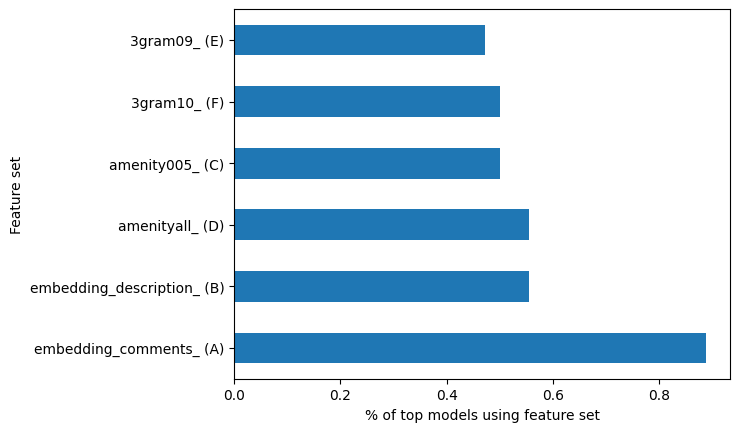

In [22]:
# split feature_set into individual feature sets
letters = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]
top["feature_set_split"] = top["feature_set"].apply(lambda x: x.split(", "))
for letter in ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]:
    top[letter] = top["feature_set_split"].apply(lambda x: letter in x)

# lets see what percent of the top models have each feature set (top models will be above 80% accuracy)
with_accuracy = top[["top_model_accuracy"] + letters]
models_above_90_accuracy = with_accuracy[with_accuracy.top_model_accuracy > 0.9]
print(f"There are {models_above_90_accuracy.shape[0]} models above 90% accuracy")
feature_set_distr = models_above_90_accuracy.sum().drop("top_model_accuracy").sort_values(ascending=False) / models_above_90_accuracy.shape[0]


# convert back to feature set name
# reverse feature_set_to_letter
feature_set_to_letter = {v: k for k, v in feature_set_to_letter.items()}
feature_set_distr.index = feature_set_distr.index.map(lambda x: feature_set_to_letter[x] + " " + x)
feature_set_distr.plot(kind="barh", xlabel="% of top models using feature set", ylabel="Feature set")

Let's grab the best subset, and hyperparameter tune the best model!

In [23]:
top_feature_set = top.reset_index().iloc[0].feature_set.split(", ")
top_feature_set = [feature_set_to_letter[f] for f in top_feature_set]
top_feature_set

['embedding_comments_', 'embedding_description_', 'amenity005_']

In [24]:
columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in top_feature_set])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['embedding_comments_0', 'embedding_comments_1', 'embedding_comments_2', 'embedding_description_0', 'embedding_description_1', 'embedding_description_2', 'amenity005_lockbox', 'amenity005_dishwasher', 'amenity005_pool', 'amenity005_keypad', 'amenity005_tv', 'amenity005_stove', 'amenity005_bathtub', 'amenity005_balcony', 'amenity005_shampoo', 'amenity005_garden', 'amenity005_cat', 'amenity005_family', 'amenity005_breakfast', 'label']


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.94


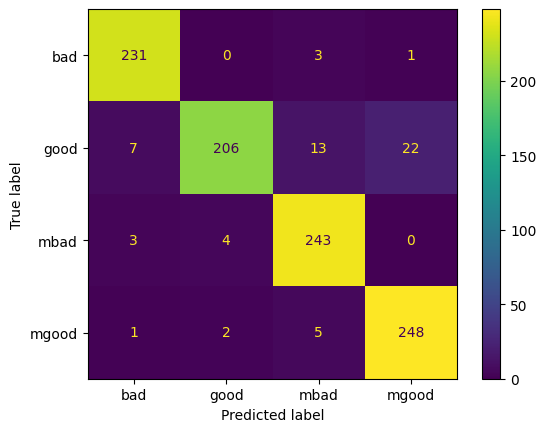

In [25]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [27]:
import plotly.express as px

best_params = clf.best_params_

# build model
etc = ExtraTreesClassifier(**best_params)

# run with 1 to 10 fold cv and plot the train and test accuracy for each
from sklearn.model_selection import cross_validate

all_scores = []

for cv in range(2, 10):
    scores = cross_validate(etc, X, y, cv=cv, scoring="accuracy", return_train_score=True)
    print(f"CV = {cv}:\n\tTrain accuracy = {round(scores['train_score'].mean(), 2)}\n\tTest accuracy = {round(scores['test_score'].mean(), 2)}")
    all_scores.append({
        "folds": cv,
        "train_accuracy": scores["train_score"].mean(),
        "test_accuracy": scores["test_score"].mean()
    })


# plot the results
all_scores_df = pd.DataFrame.from_dict(all_scores)
px.line(all_scores_df, x="folds", y=["train_accuracy", "test_accuracy"], title="Train and test accuracy for different number of folds")


CV = 2:
	Train accuracy = 1.0
	Test accuracy = 0.88
CV = 3:
	Train accuracy = 1.0
	Test accuracy = 0.9
CV = 4:
	Train accuracy = 1.0
	Test accuracy = 0.91
CV = 5:
	Train accuracy = 1.0
	Test accuracy = 0.92
CV = 6:
	Train accuracy = 1.0
	Test accuracy = 0.92
CV = 7:
	Train accuracy = 1.0
	Test accuracy = 0.92
CV = 8:
	Train accuracy = 1.0
	Test accuracy = 0.92
CV = 9:
	Train accuracy = 1.0
	Test accuracy = 0.92


# Save the model along with functions to generate features

In [28]:
pickle.dump({
    "best_clf": best_clf,
    "best_feature_set": columns_in_best_feature_set,
}, open(f"../../models/best_clf_{GEO}_3.pickle", "wb"))